In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [43]:
kcc_dataset = pd.read_csv('/Users/ronaldmatovu/Downloads/Kisan Call Centre/kcc_dataset.csv')

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/2828159761.py:1: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  kcc_dataset = pd.read_csv('/Users/ronaldmatovu/Downloads/Kisan Call Centre/kcc_dataset.csv')


In [44]:
kcc_dataset.head()

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns
0,0,0,2006,1,17,1275,SAGAR,99,RABI,HORTICULTURE,MADHYA PRADESH,how to control flower drop in bottelgourd,spray planofix4mlpump
1,0,0,2006,1,17,964,SAGAR,Disease Management,RABI,ANIMAL HUSBANDRY,MADHYA PRADESH,how tyo control diseases in buffalo,NaN
2,0,0,2006,1,17,1279,SAGAR,76,RABI,HORTICULTURE,MADHYA PRADESH,how to control fruit borer in brinjal,should be spray profenophos 35mlpump
3,0,0,2006,1,17,1064,SAGAR,3,RABI,AGRICULTURE,MADHYA PRADESH,how to control of yellow moisac in moong,should be spray metasystox 35mlpump
4,0,0,2006,1,17,1279,DAMOH,76,RABI,HORTICULTURE,MADHYA PRADESH,how to control white fly in brinjal,should be spray metasystox 35mlpump


In [45]:
kcc_dataset.sample(1000)

,BlockName,Category,Year,Month,Day,Crop,DistrictName,QueryType,Season,Sector,StateName,QueryText,KccAns
8926595,NASRULLAGANJ,Vegetables,2015,10,15,Capsicum,SEHORE,Cultural Practices,RABI,HORTICULTURE,MADHYA PRADESH,farmer want to know information about varietie...,recommended for varieties Capsicum California ...
34529415,RAJKANIKA,Cereals,2022,10,17,Paddy Dhan,KENDRAPARA,Fertilizer Use and Availability,NaN,AGRICULTURE,ODISHA,Nutrients application at panicle initiation s...,Recommended to apply 10 kg Sagarika z or Dhanz...
31729555,NALLAMPALLI,Animal,2021,12,8,BovineCowBuffalo,DHARMAPURI,Disease Reporting,NaN,ANIMAL HUSBANDRY,TAMILNADU,Asking about Animal Foot and Mouth disease rep...,: :
11565014,SAMPATCHAK,Others,2016,2,24,Others,PATNA,Weather,RABI,AGRICULTURE,BIHAR,KVK,CONTACT NO-9431664027
23689172,KANINA,Fiber Crops,2019,7,24,Cotton Kapas,MAHENDRA GARH,Plant Protection,NaN,AGRICULTURE,HARYANA,Information regarding how to control fungal di...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10838207,VIJAYIPUR,Others,2015,11,3,Others,FATEHPUR,Plant Protection,RABI,AGRICULTURE,UTTAR PRADESH,genhu ki buvai kar sakate hai,genhu ki buvai kar sakate hai
39706875,KOSIGI,Cereals,2024,5,11,Paddy Dhan,KURNOOL,Weather,NaN,AGRICULTURE,ANDHRA PRADESH,Farmer asked query on Weather,CLOUDY WEATHER NO CHANCE OF SHOWERS IN YOUR AR...
9845905,LOHIAN,Others,2015,1,8,Others,JALANDHAR,Weather,RABI,AGRICULTURE,PUNJAB,INFORMATION REGARDING WEATHER,weather is partialy cloudy today
35751418,GWALPARA,Others,2023,3,22,Others,MADHEPURA,Government Schemes,NaN,AGRICULTURE,BIHAR,Pradhan Mantri Kisan Samman Nidhi Yojana Relat...,https:dbtagriculturebihargovinCheckStatusPMKIS...


In [46]:
kcc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40163796 entries, 0 to 40163795
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   BlockName     object
 1   Category      object
 2   Year          int64 
 3   Month         int64 
 4   Day           int64 
 5   Crop          object
 6   DistrictName  object
 7   QueryType     object
 8   Season        object
 9   Sector        object
 10  StateName     object
 11  QueryText     object
 12  KccAns        object
dtypes: int64(3), object(10)
memory usage: 3.9+ GB


In [47]:
# trim all values in the dataset left and right
kcc_dataset = kcc_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/1130458048.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  kcc_dataset = kcc_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [48]:
# Group by Crops and count the number of calls
queries_by_crop = kcc_dataset.groupby('Crop')['QueryText'].count().sort_values(ascending=False)

In [49]:
queries_by_crop

Crop
Others          17751864
Paddy Dhan       3156584
Wheat            2582978
Cotton Kapas     1359291
Chillies          608677
                  ...   
8353                   1
8355                   1
8357                   1
8358                   1
8292                   1
Name: QueryText, Length: 659, dtype: int64

In [50]:
queries_by_crop.to_csv("data/EDA_outputs/queries_by_crop.csv", index=False)

In [51]:
# set the theme for the plot
sns.set_theme(style='darkgrid')
%config InlineBackend.figure_format = "svg"

In [52]:
top_10_crops = queries_by_crop.head(10)

In [53]:
top_10_crops

Crop
Others                          17751864
Paddy Dhan                       3156584
Wheat                            2582978
Cotton Kapas                     1359291
Chillies                          608677
Onion                             601001
Sugarcane Noble Cane              512484
Groundnut pea nutmung phalli      504256
Brinjal                           497279
Tomato                            488207
Name: QueryText, dtype: int64

In [54]:
top_10_crops.values

array([17751864,  3156584,  2582978,  1359291,   608677,   601001,
         512484,   504256,   497279,   488207])

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/3909193795.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])


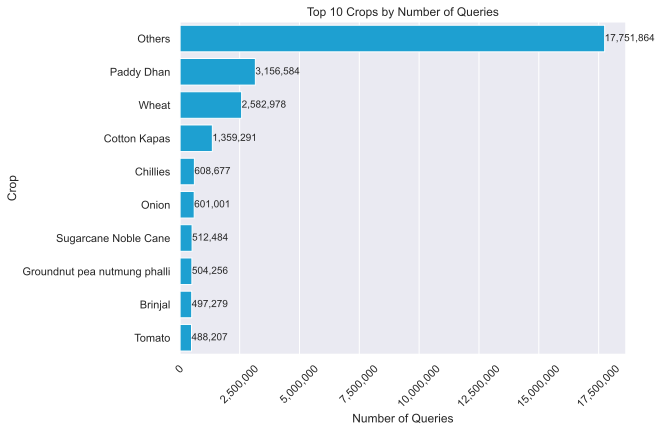

In [55]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(y=top_10_crops.index, x=top_10_crops.values, color='#00aeef')

# Format the bar labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label):,}' for label in container.datavalues], fontsize=10)

# Format the x-axis tick labels
ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])

plt.xlabel('Number of Queries')
plt.ylabel('Crop')
plt.title('Top 10 Crops by Number of Queries')
plt.xticks(rotation=45)
plt.show()


In [56]:
# create a bar blot using seaborn library for Top 10 crops for queries_by_crop use the blue color #00aeef (use the research latext figure dimension 8x6)


In [57]:
queries_by_type = kcc_dataset.groupby('QueryType')['QueryText'].count().sort_values(ascending=False)

In [58]:
queries_by_type

QueryType
Weather                14635120
Plant Protection        7630582
Government Schemes      3872820
Nutrient Management     1372265
Cultural Practices      1341791
                         ...   
Dosage                       30
46                           25
48                           24
47                           18
59                           14
Name: QueryText, Length: 144, dtype: int64

In [59]:
from operator import index


queries_by_type.to_csv("data/EDA_outputs/queries_by_type.csv", index=False)

In [60]:
top_10_queries_by_type = queries_by_type.head(10)

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/2399005483.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])


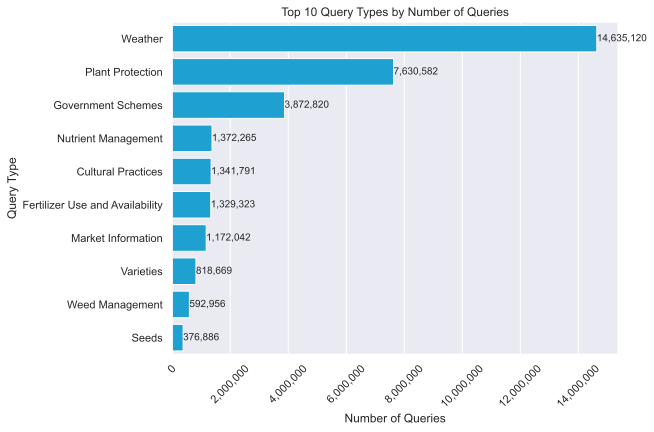

In [61]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(y=top_10_queries_by_type.index, x=top_10_queries_by_type.values, color='#00aeef')

# Format the bar labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label):,}' for label in container.datavalues], fontsize=10)

# Format the x-axis tick labels
ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])

plt.xlabel('Number of Queries')
plt.ylabel('Query Type')
plt.title('Top 10 Query Types by Number of Queries')
plt.xticks(rotation=45)
plt.show()

In [62]:
queries_by_crop_category = kcc_dataset.groupby('Category')['QueryText'].count().sort_values(ascending=False)

In [63]:
queries_by_crop_category

Category
Others                           17849507
Cereals                           5938062
Vegetables                        4628313
Fruits                            1780203
Oilseeds                          1772497
Pulses                            1614300
Fiber Crops                       1314821
0                                 1045778
Millets                            773627
Condiments and Spices              712461
Sugar and Starch Crops             603216
0                                  571610
Fodder Crops                       356361
Animal                             344017
Plantation Crops                   255042
Flowers                            182840
Medicinal and Aromatic Plants      152631
Inland                              66527
Drug and Narcotics                  37634
Avian                               20194
Beekeeping                          18431
Green Manure                        14646
Marine                               5367
417                      

In [64]:
top_10_queries_by_crop_category = queries_by_crop_category.head(10)

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/2257955997.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])


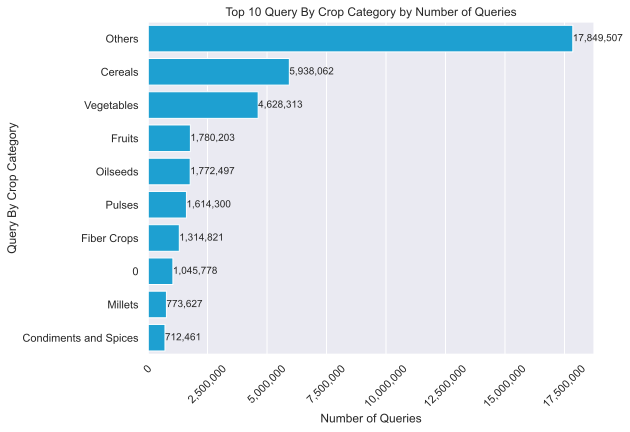

In [65]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(y=top_10_queries_by_crop_category.index, x=top_10_queries_by_crop_category.values, color='#00aeef')

# Format the bar labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(label):,}' for label in container.datavalues], fontsize=10)

# Format the x-axis tick labels
ax.set_xticklabels([f'{int(label):,}' for label in ax.get_xticks()])

plt.xlabel('Number of Queries')
plt.ylabel('Query By Crop Category')
plt.title('Top 10 Query By Crop Category by Number of Queries')
plt.xticks(rotation=45)
plt.show()

In [66]:
top_10_queries_by_crop_category.to_csv("data/EDA_outputs/queries_by_crop_category.csv", index=False)

In [67]:
# List of query types to exclude
query_types_to_exclude = [
    "Government Schemes",
    "Cultural Practices",
    "Market Information",
    "Sowing Time and Weather",
    "Crop Insurance", 
    "Training and Exposure Visits", 
    "Credit", 
    "Power Roads etc", 
    "Coastal Aquaculture",
    "Others", 
    "Loans",
    # filter all the numerical values
]

In [68]:
filtered_kcc_dataset_excluding_types = kcc_dataset[~kcc_dataset['QueryType'].isin(query_types_to_exclude)]


In [69]:
filtered_kcc_dataset_excluding_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33113029 entries, 0 to 40163795
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   BlockName     object
 1   Category      object
 2   Year          int64 
 3   Month         int64 
 4   Day           int64 
 5   Crop          object
 6   DistrictName  object
 7   QueryType     object
 8   Season        object
 9   Sector        object
 10  StateName     object
 11  QueryText     object
 12  KccAns        object
dtypes: int64(3), object(10)
memory usage: 3.5+ GB


In [70]:
# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [71]:
# Filter the dataset to exclude rows where QueryType is numeric
filtered_kcc_dataset_non_numeric = filtered_kcc_dataset_excluding_types[~filtered_kcc_dataset_excluding_types['QueryType'].apply(is_numeric)]

In [72]:
filtered_kcc_dataset_non_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28820171 entries, 1 to 40163795
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   BlockName     object
 1   Category      object
 2   Year          int64 
 3   Month         int64 
 4   Day           int64 
 5   Crop          object
 6   DistrictName  object
 7   QueryType     object
 8   Season        object
 9   Sector        object
 10  StateName     object
 11  QueryText     object
 12  KccAns        object
dtypes: int64(3), object(10)
memory usage: 3.0+ GB


In [73]:
filtered_kcc_dataset_non_numeric_by_query_type = filtered_kcc_dataset_non_numeric.groupby('QueryType')['QueryText'].count().sort_values(ascending=False) 

In [74]:
filtered_kcc_dataset_non_numeric_by_query_type

QueryType
Weather                                14635120
Plant Protection                        7630582
Nutrient Management                     1372265
Fertilizer Use and Availability         1329323
Varieties                                818669
                                         ...   
Fishing Harbours and Landing Centre         354
Seaweed Cultivation                         303
Varities                                    214
Feed                                        168
Dosage                                       30
Name: QueryText, Length: 63, dtype: int64

In [75]:
filtered_kcc_dataset_non_numeric_by_query_type.to_csv("data/EDA_outputs/filtered_kcc_dataset_non_numeric_by_query_type.csv", index=False)

In [76]:
# Get only crop for "Groundnut pea nutmung phalli" from the dataset filtered_kcc_dataset_non_numeric
filtered_kcc_dataset_non_numeric_with_only_gnuts = filtered_kcc_dataset_non_numeric[filtered_kcc_dataset_non_numeric['Crop'] == 'Groundnut pea nutmung phalli']

In [77]:
filtered_kcc_dataset_non_numeric_with_only_gnuts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372750 entries, 432 to 40163704
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   BlockName     372750 non-null  object
 1   Category      372750 non-null  object
 2   Year          372750 non-null  int64 
 3   Month         372750 non-null  int64 
 4   Day           372750 non-null  int64 
 5   Crop          372750 non-null  object
 6   DistrictName  372750 non-null  object
 7   QueryType     372750 non-null  object
 8   Season        101542 non-null  object
 9   Sector        372750 non-null  object
 10  StateName     372750 non-null  object
 11  QueryText     372712 non-null  object
 12  KccAns        338527 non-null  object
dtypes: int64(3), object(10)
memory usage: 39.8+ MB


In [78]:
filtered_kcc_dataset_non_numeric_with_only_gnuts.to_csv("data/EDA_outputs/filtered_kcc_dataset_non_numeric_with_only_gnuts.csv", index=False)

In [86]:
kcc_dataset_QA = pd.read_csv("data/EDA_outputs/filtered_kcc_dataset_non_numeric_with_only_gnuts.csv")

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/3571984019.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  kcc_dataset_QA = pd.read_csv("data/EDA_outputs/filtered_kcc_dataset_non_numeric_with_only_gnuts.csv")


In [87]:
kcc_dataset_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372750 entries, 0 to 372749
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   BlockName     372750 non-null  object
 1   Category      372750 non-null  object
 2   Year          372750 non-null  int64 
 3   Month         372750 non-null  int64 
 4   Day           372750 non-null  int64 
 5   Crop          372750 non-null  object
 6   DistrictName  372750 non-null  object
 7   QueryType     372750 non-null  object
 8   Season        101542 non-null  object
 9   Sector        372750 non-null  object
 10  StateName     372750 non-null  object
 11  QueryText     372683 non-null  object
 12  KccAns        321918 non-null  object
dtypes: int64(3), object(10)
memory usage: 37.0+ MB


In [88]:
# Select the QueryText and KccAns columns only
kcc_dataset_QA = kcc_dataset_QA[['QueryText', 'KccAns']]

In [89]:
kcc_dataset_QA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372750 entries, 0 to 372749
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   QueryText  372683 non-null  object
 1   KccAns     321918 non-null  object
dtypes: object(2)
memory usage: 5.7+ MB


In [93]:
# Return the total of null values
kcc_dataset_QA.isnull().sum()

QueryText       67
KccAns       50832
dtype: int64

In [94]:
# Return the total of duplicate rows
kcc_dataset_QA.duplicated().sum()

189859

In [95]:
# Return the duplicate rows in data frame
sorted_duplicates = kcc_dataset_QA[kcc_dataset_QA.duplicated()].sort_values(by=kcc_dataset_QA.columns.tolist())
sorted_duplicates


,QueryText,KccAns
55449,-,- - - -- ------ -- -
55628,-,- - - -- ------ -- -
86446,-,- - - -- ------ -- -
86456,-,- - - -- ------ -- -
86514,-,- - - -- ------ -- -
...,...,...
186261,NaN,NaN
186455,NaN,NaN
206434,NaN,NaN
208657,NaN,NaN


In [98]:
non_agricultural_questions = [
    "What is the capital of France?",
    "How does a computer work?",
    "What is the formula for water?",
    "Who wrote 'To Kill a Mockingbird'?",
    "What is the speed of light?",
    "How many continents are there?",
    "What is the largest planet in our solar system?",
    "Who was the first president of the United States?",
    "What is the currency of Japan?",
    "How do airplanes fly?",
    "What is the boiling point of water?",
    "Who painted the Mona Lisa?",
    "What is the tallest mountain in the world?",
    "What is the main ingredient in sushi?",
    "How does the human heart work?",
    "What is the chemical symbol for gold?",
    "Who invented the telephone?",
    "What is quantum mechanics?",
    "How do you make a paper airplane?",
    "What is the purpose of photosynthesis?",
    "What is the distance between the Earth and the Moon?",
    "Who is the author of '1984'?",
    "What is the hardest natural substance on Earth?",
    "How does the internet work?",
    "What is the theory of relativity?",
    "What is the largest ocean on Earth?",
    "Who discovered penicillin?",
    "What is the longest river in the world?",
    "What is the name of the galaxy we live in?",
    "What is the freezing point of water?",
    "Who developed the theory of evolution?",
    "What is the atomic number of carbon?",
    "How many bones are in the human body?",
    "What is the speed of sound?",
    "What is the primary function of the lungs?",
    "Who is the current president of the United States?",
    "What is the capital of Japan?",
    "How many states are there in the USA?",
    "What is the primary ingredient in bread?",
    "Who painted the Sistine Chapel ceiling?",
    "What is the boiling point of water in Fahrenheit?",
    "What is the chemical formula for table salt?",
    "What is the highest mountain in North America?",
    "Who wrote 'Pride and Prejudice'?",
    "What is the primary function of the kidneys?",
    "What is the circumference of the Earth?",
    "Who was the first person to walk on the Moon?",
    "What is the largest desert in the world?",
    "What is the main component of the Sun?",
    "What is the function of red blood cells?",
    "What is the capital of Australia?",
    "How many planets are in our solar system?",
    "What is the most abundant gas in Earth's atmosphere?",
    "Who invented the light bulb?",
    "What is the currency of the United Kingdom?",
    "What is the tallest building in the world?",
    "What is the chemical symbol for oxygen?",
    "How many chromosomes do humans have?",
    "What is the process of cell division called?",
    "What is the primary source of energy for the Earth?",
    "What is the speed limit of light in a vacuum?",
    "Who wrote 'The Odyssey'?",
    "What is the hardest metal?",
    "How do plants make their food?",
    "What is the distance between the Earth and the Sun?",
    "Who is known as the father of modern physics?",
    "What is the largest mammal in the world?",
    "What is the pH level of pure water?",
    "What is the function of white blood cells?",
    "What is the capital of Canada?",
    "How many moons does Jupiter have?",
    "What is the function of the liver?",
    "What is the main ingredient in chocolate?",
    "Who discovered gravity?",
    "What is the main function of the brain?",
    "What is the chemical formula for carbon dioxide?",
    "What is the tallest mountain in Europe?",
    "Who wrote 'The Great Gatsby'?",
    "What is the main ingredient in ice cream?",
    "What is the primary function of the heart?",
    "What is the speed of the Earth's rotation?",
    "What is the smallest particle of an element?",
    "Who painted 'Starry Night'?",
    "What is the boiling point of ethanol?",
    "What is the primary function of the digestive system?",
    "Who is the CEO of Tesla?",
    "What is the capital of Germany?",
    "How many countries are in the European Union?",
    "What is the main ingredient in pizza dough?",
    "Who wrote 'Moby Dick'?",
    "What is the primary function of the immune system?",
    "What is the distance around the Earth at the equator?",
    "What is the primary function of the respiratory system?",
    "Who invented the airplane?",
    "What is the capital of Italy?",
    "How many countries are in Africa?",
    "What is the main ingredient in pasta?",
    "Who painted 'The Last Supper'?",
    "What is the primary function of the nervous system?",
    "What is the highest waterfall in the world?",
    "What is the primary function of the skeletal system?",
    "Who discovered America?",
    "What is the capital of Russia?",
    "How many countries are in South America?",
    "What is the main ingredient in bread dough?",
    "Who wrote 'Hamlet'?",
    "What is the primary function of the muscular system?",
    "What is the highest volcano in the world?",
    "What is the primary function of the endocrine system?",
    "Who was the first female president?",
    "What is the capital of China?",
    "How many countries are in Asia?",
    "What is the main ingredient in beer?",
    "Who painted 'The Persistence of Memory'?",
    "What is the primary function of the circulatory system?",
    "What is the longest river in Africa?",
    "What is the primary function of the lymphatic system?",
    "Who invented the steam engine?",
    "What is the capital of India?",
    "How many countries are in Oceania?",
    "What is the main ingredient in whiskey?",
    "Who wrote 'War and Peace'?",
    "What is the primary function of the reproductive system?",
    "What is the tallest tree in the world?",
    "What is the primary function of the urinary system?",
    "Who discovered penicillin?",
    "What is the capital of Brazil?",
    "How many countries are in North America?",
    "What is the main ingredient in wine?",
    "Who painted 'Guernica'?",
    "What is the primary function of the integumentary system?",
    "What is the largest lake in the world?",
    "What is the primary function of the sensory system?",
    "Who invented the telephone?",
    "What is the capital of Mexico?",
    "How many countries are in the Middle East?",
    "What is the main ingredient in coffee?",
    "Who wrote 'The Catcher in the Rye'?",
    "What is the primary function of the immune system?",
    "What is the tallest building in the world?",
    "What is the primary function of the skeletal system?",
    "Who discovered the Americas?",
    "What is the capital of the United Kingdom?",
    "How many countries are in Central America?",
    "What is the main ingredient in tea?",
    "Who painted 'The Birth of Venus'?",
    "What is the primary function of the nervous system?",
    "What is the highest peak in North America?",
    "What is the primary function of the digestive system?",
    "Who invented the electric light bulb?",
    "What is the capital of Australia?",
    "How many countries are in the European Union?",
    "What is the main ingredient in vodka?",
    "Who wrote 'Pride and Prejudice'?",
    "What is the primary function of the circulatory system?",
    "What is the deepest part of the ocean?",
    "What is the primary function of the lymphatic system?",
    "Who invented the internal combustion engine?",
    "What is the capital of Egypt?",
    "How many countries are in the world?",
    "What is the main ingredient in beer?",
    "Who painted 'The Night Watch'?",
    "What is the primary function of the respiratory system?",
    "What is the longest river in the United States?",
    "What is the primary function of the urinary system?",
    "Who discovered insulin?",
    "What is the capital of South Korea?",
    "How many countries are in Africa?",
    "What is the main ingredient in cider?",
    "Who wrote 'The Hobbit'?",
    "What is the primary function of the reproductive system?",
    "What is the largest island in the world?",
    "What is the primary function of the endocrine system?",
    "Who invented the World Wide Web?",
    "What is the capital of Spain?",
    "How many countries are in South America?",
    "What is the main ingredient in gin?",
    "Who painted 'The Scream'?",
    "What is the primary function of the integumentary system?",
    "What is the longest river in Europe?",
    "What is the primary function of the sensory system?",
    "Who invented the printing press?",
    "What is the capital of Canada?",
    "How many countries are in North America?",
    "What is the main ingredient in rum?",
    "Who wrote 'The Grapes of Wrath'?",
    "What is the primary function of the skeletal system?",
    "What is the largest ocean on Earth?",
    "What is the primary function of the circulatory system?",
    "Who invented the computer?",
    "What is the deepest lake in the world?",
    "What is the primary function of the lymphatic system?",
    "Who invented the telephone?",
    "What is the capital of Australia?",
    "How many countries are in the European Union?",
    "What is the main ingredient in whiskey?",
    "What is the capital of Sweden?",
    "How does a light bulb work?",
    "What is the speed of a cheetah?",
    "Who is the founder of Microsoft?",
    "What is the chemical symbol for iron?",
    "How do volcanoes erupt?",
    "What is the main ingredient in ketchup?",
    "Who invented the automobile?",
    "What is the distance from Earth to Mars?",
    "How do magnets work?",
    "What is the highest peak in Africa?",
    "Who discovered electricity?",
    "What is the function of mitochondria?",
    "How many elements are in the periodic table?",
    "What is the currency of Canada?",
    "Who is the author of 'The Great Gatsby'?",
    "What is the boiling point of nitrogen?",
    "How does the circulatory system work?",
    "What is the capital of Brazil?",
    "Who invented the radio?",
    "What is the speed of sound in water?",
    "How many countries are in Europe?",
    "What is the main ingredient in hummus?",
    "Who painted 'The Persistence of Memory'?",
    "How do airplanes stay in the air?",
    "What is the highest mountain in South America?",
    "Who discovered radioactivity?",
    "What is the primary function of DNA?",
    "What is the capital of South Africa?",
    "How many bones are in the human hand?",
    "What is the speed of a spaceship?",
    "Who wrote 'The Iliad'?",
    "What is the chemical symbol for sodium?",
    "How does the immune system work?",
    "What is the capital of Argentina?",
    "Who invented the washing machine?",
    "What is the distance from Earth to Jupiter?",
    "How do plants reproduce?",
    "What is the highest peak in Europe?",
    "Who discovered X-rays?",
    "What is the function of chlorophyll?",
    "How many muscles are in the human body?",
    "What is the currency of Mexico?",
    "Who is the author of 'Moby Dick'?",
    "What is the boiling point of mercury?",
    "How does the digestive system work?",
    "What is the capital of Colombia?",
    "Who invented the television?",
    "What is the speed of a bullet?",
    "How many countries are in North America?",
    "What is the main ingredient in pasta?",
    "Who painted 'Starry Night'?",
    "How do fish breathe?",
    "What is the highest mountain in Asia?",
    "Who discovered penicillin?",
    "What is the primary function of RNA?",
    "What is the capital of Chile?",
    "How many bones are in the human foot?",
    "What is the speed of light in water?",
    "Who wrote 'Pride and Prejudice'?",
    "What is the chemical symbol for helium?",
    "How does the brain work?",
    "What is the capital of Peru?",
    "Who invented the internet?",
    "What is the distance from Earth to Venus?",
    "How do trees grow?",
    "What is the highest peak in North America?",
    "Who discovered the electron?",
    "What is the function of the liver?",
    "How many joints are in the human body?",
    "What is the currency of Australia?",
    "Who is the author of '1984'?",
    "What is the boiling point of water in Celsius?",
    "How does the respiratory system work?",
    "What is the capital of New Zealand?",
    "Who invented the telephone?",
    "What is the speed of a jet?",
    "How many countries are in Africa?",
    "What is the main ingredient in bread?",
    "Who painted 'The Last Supper'?",
    "How do birds fly?",
    "What is the highest mountain in the world?",
    "Who discovered the neutron?",
    "What is the primary function of enzymes?",
    "What is the capital of Egypt?",
    "How many bones are in the human leg?",
    "What is the speed of electricity?",
    "Who wrote 'The Catcher in the Rye'?",
    "What is the chemical symbol for calcium?",
    "How does the heart work?",
    "What is the capital of Nigeria?",
    "Who invented the light bulb?",
    "What is the distance from Earth to Pluto?",
    "How do insects breathe?",
    "What is the highest peak in Australia?",
    "Who discovered gravity?",
    "What is the function of white blood cells?",
    "How many ribs are in the human body?",
    "What is the currency of Japan?",
    "Who is the author of 'To Kill a Mockingbird'?",
    "What is the boiling point of ethanol?",
    "How does the endocrine system work?",
    "What is the capital of Turkey?",
    "Who invented the computer?",
    "What is the speed of a train?",
    "How many countries are in Asia?",
    "What is the main ingredient in rice?",
    "Who painted 'Guernica'?",
    "How do plants photosynthesize?",
    "What is the highest mountain in Antarctica?",
    "Who discovered the proton?",
    "What is the primary function of neurons?",
    "What is the capital of Thailand?",
    "How many bones are in the human arm?",
    "What is the speed of a tornado?",
    "Who wrote 'War and Peace'?",
    "What is the chemical symbol for potassium?",
    "How does the digestive system work?",
    "What is the capital of Kenya?",
    "Who invented the printing press?",
    "What is the distance from Earth to Saturn?",
    "How do fungi reproduce?",
    "What is the highest peak in South America?",
    "Who discovered the DNA structure?",
    "What is the function of red blood cells?",
    "How many vertebrae are in the human spine?",
    "What is the currency of India?",
    "Who is the author of 'The Great Gatsby'?",
    "What is the boiling point of propane?",
    "How does the muscular system work?",
    "What is the capital of Greece?",
    "Who invented the microscope?",
    "What is the speed of a hurricane?",
    "How many countries are in Europe?",
    "What is the main ingredient in yogurt?",
    "Who painted 'The Birth of Venus'?",
    "How do bacteria reproduce?",
    "What is the highest mountain in North America?",
    "Who discovered penicillin?",
    "What is the primary function of chloroplasts?",
    "What is the capital of Saudi Arabia?",
    "How many bones are in the human head?",
    "What is the speed of a rocket?",
    "Who wrote 'The Iliad'?",
    "What is the chemical symbol for nitrogen?",
    "How does the nervous system work?",
    "What is the capital of Vietnam?",
    "Who invented the refrigerator?",
    "What is the distance from Earth to Neptune?",
    "How do viruses replicate?",
    "What is the highest peak in Africa?",
    "Who discovered radioactivity?",
    "What is the function of platelets?",
    "How many muscles are in the human hand?",
    "What is the currency of Russia?",
    "Who is the author of 'Moby Dick'?",
    "What is the boiling point of hydrogen?",
    "How does the skeletal system work?",
    "What is the capital of Iran?",
    "Who invented the washing machine?",
    "What is the speed of a car?",
    "How many countries are in the world?",
    "What is the main ingredient in cheese?",
    "Who painted 'The Scream'?",
    "How do cells divide?",
    "What is the highest mountain in Europe?",
    "Who discovered X-rays?",
    "What is the primary function of mitochondria?",
    "What is the capital of Pakistan?",
    "How many bones are in the human spine?",
    "What is the speed of a horse?",
    "Who wrote 'Pride and Prejudice'?",
    "What is the chemical symbol for sulfur?",
    "How does the immune system work?",
    "What is the capital of Indonesia?",
    "Who invented the television?",
    "What is the distance from Earth to Uranus?",
    "How do plants grow?",
    "What is the highest peak in Australia?",
    "Who discovered the electron?",
    "What is the function of the kidneys?",
    "How many joints are in the human body?",
    "What is the currency of Brazil?",
    "Who is the author of '1984'?",
    "What is the boiling point of methane?",
    "How does the circulatory system work?",
    "What is the capital of the Philippines?",
    "Who invented the telephone?",
    "What is the speed of a ship?",
    "How many countries are in North America?",
    "What is the main ingredient in tofu?",
    "Who painted 'The Persistence of Memory'?",
    "How do animals reproduce?",
    "What is the highest mountain in Antarctica?",
    "Who discovered the proton?",
    "What is the primary function of ribosomes?",
    "What is the capital of Malaysia?",
    "How many bones are in the human foot?",
    "What is the speed of a motorcycle?",
    "Who wrote 'The Catcher in the Rye'?",
    "What is the chemical symbol for chlorine?",
    "How does the brain work?",
    "What is the capital of Ukraine?",
    "Who invented the airplane?",
    "What is the distance from Earth to the Sun?",
    "How do fish swim?",
    "What is the highest peak in the United States?",
    "Who discovered the neutron?",
    "What is the function of hemoglobin?",
    "How many ribs are in the human body?",
    "What is the currency of the United Kingdom?",
]

In [99]:
len(non_agricultural_questions)

407

In [100]:
import random


def generate_synthentic_data(non_agricultural_questions):
    # Define a list of non-agricultural topics and sample questions

    # Define the consistent answer for non-agricultural questions
    consistent_answer = "Apologies, the AI service can only answer agriculture-related questions."

    # Generate the synthetic dataset
    synthetic_data = {"QueryText": [], "KccAns": []}

    # Generate a random non-agricultural question
    for _ in range(8000):
        question = random.choice(non_agricultural_questions)
        synthetic_data["QueryText"].append(question)
        synthetic_data["KccAns"].append(consistent_answer)

    # Convert to DataFrame
    synthetic_dataset = pd.DataFrame(synthetic_data)

In [104]:
import re

# Function to check if a string contains more than 5 numerical values
def contains_more_than_5_numerical_values(text):
    return len(re.findall(r'\d', text)) > 5

# List of strings to check for and their variants
strings_to_check = [
    "given him information as per dose",
    "recommended as per the data",
    "EXPLAIN IN DETAILS",
    "information is given as per panchangam",
    "recommended as per dose",
    "recommended according to panchangam",
    "explained as per data",
    "given information as per data",
    "given",
    "recomended fertiliser schedule",
    "explained as per fertiliser schedule",
    "recomended as per schedule",
    "GIVEN IN DETAILS AS PER THE RECOMMENDED DOS",
    "given the information",
    "Give proper information",
    "Provide Information on GNut Fertilizer Dose",
    "Provided detail about Irrigation",
    "Provide Detail Information on GNut Fertilizer",
    "info-provided",
    "Give proper information",
    "IONFORMATION PROVIDED",
    "i sugg to information",
    "Giving the proper information",
    "information given",
    "given as per data",
    "gave information",
    "provided information about it",
    "provided information about it",
    "if essential",
    "i give information for it",
    "info provide",
    "provide all information",
    "information given",
    "as per recomdation",
    "provide information",
    "as per data",
    "info  given",
    "as per recomanded",
    "provide all information",
    "INFOGIVEN"
]

# Function to check if a string contains any of the specified strings or their variants
def contains_specified_strings(text):
    for string in strings_to_check:
        if re.search(re.escape(string), text, re.IGNORECASE):
            return True
    return False

# Function to clean the DataFrame based on the specified conditions
def remove_non_informative_strings_and_numerical_values(df):
    # Drop rows where KccAns contains more than 5 numerical values
    df = df[~df['KccAns'].apply(contains_more_than_5_numerical_values)]
    
    # Drop rows where KccAns contains any of the specified strings or their variants
    df = df[~df['KccAns'].apply(contains_specified_strings)]
    
    return df

In [105]:
# Split the dataset into training, validation, and test sets using the 80%, 10%, 10% split. Also convert the dataset into huggingface dataset format.
def pre_process_data(data):
    
    # Remove the rows with empty values
    data = data.dropna()

    # Remove the rows with duplicate values
    data = data.drop_duplicates()

    # Add synthentic data to the dataset to force the model to stick to only agriculture related queries
    synthetic_data = generate_synthentic_data(non_agricultural_questions)
    data = pd.concat([data, synthetic_data], ignore_index=True)

    # Remove KccAns with more than 5 numerical values and KccAns with specified strings
    data = remove_non_informative_strings_and_numerical_values(data)

    # Split the dataset into training, validation, and test sets using the 80%, 10%, 10% split
    train_dataset, val_test_dataset = train_test_split(data, test_size=0.2, random_state=42)
    val_dataset, test_dataset = train_test_split(val_test_dataset, test_size=0.5, random_state=42)

    # convert the dataset into huggingface dataset format
    train_dataset = Dataset.from_pandas(train_dataset)
    val_dataset = Dataset.from_pandas(val_dataset)
    test_dataset = Dataset.from_pandas(test_dataset)

    dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset, 'test': test_dataset})
    
    return dataset

In [106]:
kcc_dataset_QA_clean = pre_process_data(kcc_dataset_QA)
kcc_dataset_QA_clean

DatasetDict({
    train: Dataset({
        features: ['QueryText', 'KccAns', '__index_level_0__'],
        num_rows: 69666
    })
    validation: Dataset({
        features: ['QueryText', 'KccAns', '__index_level_0__'],
        num_rows: 8708
    })
    test: Dataset({
        features: ['QueryText', 'KccAns', '__index_level_0__'],
        num_rows: 8709
    })
})

In [113]:

kcc_dataset_QA_clean.push_to_hub("matovu-ronald/kisan_call_centre_groundnut_crop_QA_dataset_cleaned")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/70 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/matovu-ronald/kisan_call_centre_groundnut_crop_QA_dataset_cleaned/commit/6d1150cbae9852d03083b273d0c850e0a773c90b', commit_message='Upload dataset', commit_description='', oid='6d1150cbae9852d03083b273d0c850e0a773c90b', pr_url=None, pr_revision=None, pr_num=None)

In [82]:
# Load the dataset, shuffle the dataset, create train, validation and test splits using huggingface datasets library

kisan_call_center_dataset_groundnut_queries = load_dataset('csv', data_files='data/EDA_outputs/filtered_kcc_dataset_non_numeric_with_only_gnuts.csv')



Generating train split: 0 examples [00:00, ? examples/s]

In [83]:
kisan_call_center_dataset_groundnut_queries

DatasetDict({
    train: Dataset({
        features: ['BlockName', 'Category', 'Year', 'Month', 'Day', 'Crop', 'DistrictName', 'QueryType', 'Season', 'Sector', 'StateName', 'QueryText', 'KccAns'],
        num_rows: 372750
    })
})

In [79]:
# Load your dataset
file_path = 'data/EDA_outputs/filtered_kcc_dataset_non_numeric_with_only_gnuts.csv'
kcc_dataset_V2 = pd.read_csv(file_path)

# Filter out rows with empty answers
kcc_dataset_V2 = kcc_dataset_V2.dropna(subset=['QueryText', 'KccAns'])

/var/folders/0d/975d1jtj1v5692v1l52lsc5w0000gn/T/ipykernel_9218/649842866.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  kcc_dataset_V2 = pd.read_csv(file_path)


In [1]:
from datasets import load_dataset

ds = load_dataset("matovu-ronald/kisan_call_centre_groundnut_crop_QA_dataset_cleaned")

Generating train split:   0%|          | 0/69666 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8708 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8709 [00:00<?, ? examples/s]

In [5]:
# save the train, validation, and test dataset as a csv file with the __index_level_0__ column deleted
ds['train'].to_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_train.csv', index=False)
ds['validation'].to_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_validation.csv', index=False)
ds['test'].to_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_test.csv', index=False)

# Load the train, validation, and test dataset from the csv file
kcc_dataset_QA_cleaned_train = pd.read_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_train.csv')
kcc_dataset_QA_cleaned_validation = pd.read_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_validation.csv')
kcc_dataset_QA_cleaned_test = pd.read_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_test.csv')

# Combine into a single dataset
kcc_dataset_QA_cleaned = pd.concat([kcc_dataset_QA_cleaned_train, kcc_dataset_QA_cleaned_validation, kcc_dataset_QA_cleaned_test])

Creating CSV from Arrow format:   0%|          | 0/70 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

In [7]:
# Drop the __index_level_0__ column
kcc_dataset_QA_cleaned = kcc_dataset_QA_cleaned.drop(columns='__index_level_0__')

In [8]:
kcc_dataset_QA_cleaned.to_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_60K.csv', index=False)

In [2]:
from joblib import Parallel, delayed

In [3]:
from openai import OpenAI
from dotenv import load_dotenv
import os
# Load the .env file
load_dotenv()

# Get the API key from the .env file
api_key = os.getenv('OPENAI_API_KEY')

# Initialize the OpenAI client
client = OpenAI(api_key=api_key)

In [4]:
def correct_grammar(text):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that corrects grammar while preserving the original meaning."},
            {"role": "user", "content": f"Correct the grammar of the following text, maintaining its original meaning, and use lowercase: '{text}'"}
            ]
        )

    return response.choices[0].message.content

In [5]:
# Load your dataset
df = pd.read_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_60K.csv')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87083 entries, 0 to 87082
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   QueryText  87083 non-null  object
 1   KccAns     87083 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [18]:
# split the df dataset into 10 parts and save each file as a csv file
n = 15
dfs = np.array_split(df, n)
Parallel(n_jobs=n)(delayed(lambda i, df: df.to_csv(f'data/EDA_outputs/parts/kcc_dataset_QA_cleaned_60K_{i}.csv', index=False))(i, dfs[i]) for i in range(n))


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [19]:
sample_0 = pd.read_csv('data/EDA_outputs/parts/kcc_dataset_QA_cleaned_60K_0.csv')

In [20]:
sample_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5806 entries, 0 to 5805
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   QueryText  5806 non-null   object
 1   KccAns     5806 non-null   object
dtypes: object(2)
memory usage: 90.8+ KB


In [6]:
#select 10 rows from the dataset
df_sample = df.sample(1000)


In [9]:
# Function to apply correction in parallel
def parallel_apply(data, func, n_jobs=4):
    # Split the data into chunks
    chunks = np.array_split(data, n_jobs)
    # Apply the function to each chunk in parallel
    results = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(lambda chunk: chunk.apply(func))(chunk) for chunk in chunks)
    # Concatenate the results back into a single series
    return pd.concat(results)

In [10]:
df_sample['corrected_answer'] = parallel_apply(df_sample['KccAns'], correct_grammar, n_jobs=4)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [38]:
df_sample

,QueryText,KccAns,corrected_answer
18694,FERTILIZER MANAGEMENT IN GROUNDNUT,RECOMMENDED TO APPLY UREA: 13 KGSMOP: 20 KGS,recommended to apply urea: 13 kgs mop: 20 kgs
46529,Farmer asked query on Weather,: - : : 35 C 25 C 8,': - : : 35 °C 25 °C 8'
34121,FERTILISER,GYPSUM AND 18 46,'gypsum and 18 46'
55449,what is take to urea now this time in groundnut,use only basal dose not reccommended top drasi...,'use only the basal dose; top dressing of urea...
61557,asking about groundnut water management,recommended for In pod development stage 2 - 3...,'recommended for in pod development stage 2 - ...
22983,Farmer asked query on Weather,- - - - - -,- - - - - -
15446,Farmer asked about Gypsum application in groun...,Recommended to apply 200 kg Gypsum per acre ne...,recommended to apply 200 kg of gypsum per acre...
30123,FERTILISER USE IN GROUND NUT,USE OF SSP AND POTASH BEFORE SOWING,'use of ssp and potash before sowing'
39545,plant protection,Spray Actra 5 gm redomilgold 30 gm 15 Lit of ...,"'spray actra 5 gm, redomil gold 30 gm, 15 lite..."
58708,CONTROL TIKKA DEASE IN GROUNDNUT,SPRAY OF CARBENDAZIM 12 MANCOZEB 63 WP 2 G...,'spray of carbendazim 12 mancozeb 63 wp 2 gram...


In [33]:
# Correct the grammar of the KccAns column
df['corrected_answer'] = df['KccAns'].apply(correct_grammar)

KeyboardInterrupt: 

In [ ]:
# Save the corrected dataset
df.to_csv('data/EDA_outputs/kcc_dataset_QA_cleaned_60K_corrected_dataset.csv', index=False)

In [30]:
df.head()

,QueryText,KccAns
0,GROUNDNUT VERITIES,GROUNDNUT VERITIES -TAG 24 TG 26
1,ASKED ABOUT SOWING TIME OF GROUND NUT,SOWING TIME OF GROUND NUT-IT GENERALLY CULTIVA...
2,TELL ME CONTROL LAT IN GROUNDNUT,SPRAY OF PROFENOFOS 15 ML PER LITER WATER
3,weed management in groundnut,hand weeding
4,Farmer wants to know about fungal disease mana...,-- -
